In [83]:
import numpy as np
import cmath
import math
import matplotlib.pyplot as plt 

In [2]:
def despreader(Tss_, gold, M=1):   
    symbols = []
    
    for i in range(len(Tss_)):
        Tss_[i] = Tss_[i] * gold[i%len(gold)]
        
    while len(Tss_) != 0:
        symbol = sum(Tss_[:M])/M
        symbols.append(symbol)
        Tss_ = Tss_[M:]
    return symbols

In [3]:
def channel(T, SNRin = None, jammer = None):
    #SNRin should be given in dB
    #k is the signal attenuation of the channel
    #jammer is a tuple with the jamming message and the power of the jammer
    #jammer[0] is the jamming message, jammer[1] is the relative power of the jamming signal in dBs compared to the message signal
    
    if SNRin is not None:
        Ps = signalPower(T)
        SNRlin = 10**(SNRin/10)
        Pn = Ps/SNRlin
        T = [t + complex(np.random.normal(scale = math.sqrt(Pn)), np.random.normal(scale = math.sqrt(Pn))) for t in T]
    
    if jammer is not None:
        T = [t+i for t, i in list(zip(T, jammer))]
    return T

def signalPower(T):
    summation = 0
    for i in T:
        summation += (abs(i))**2
    return summation/len(T)

In [45]:
def errorCount(Rx, Tx, percent = False):
    Rx = ''.join(sourceEncoder(Rx))
    Tx = ''.join(sourceEncoder(Tx))
    errorCount = 0
    for r, t in list(zip(Rx, Tx)):
        if r != t:
            errorCount += 1
    if percent:
        return errorCount / len(Rx)
    else:
        return errorCount

In [5]:
def spreader(T, gold, M = 1):
    
    #M is how many values from gold are 'allocated' to each symbol. Therefore the output length will be len(T)*M
    
    output = np.repeat(T, M)
    for i in range(len(output)):
        output[i] = output[i] * gold[i%len(gold)]
    
    return output  

In [6]:
def generateGold(polynomials, offset=0):
    PN1 = PN(polynomials[0])
    PN2 = PN(polynomials[1])
    gold = [0] * len(PN1)
    for i in range(len(PN1)):
        temp = PN1[i]
        
        if i+offset < len(PN2):
            temp += PN2[i+offset]
        else:
            temp += PN2[i+offset-len(PN2)]
        gold[i] = temp % 2
    gold = [1-2*i for i in gold]
    return gold
    

In [7]:
def PN(polynomial): 
    PN = [1] 
    initial = [1] * max(polynomial) 
    state = [1] * max(polynomial) 
    polynomial = polynomial[1:] 
    polynomial = [i + 1 for i in polynomial] 

    while True:
        new = state[-1]
        for i in polynomial:
            new += state[-i]
        new = new % 2
        state.insert(0, new)
        state.pop(-1)
        if state == initial: break
        PN.append(state[-1])
    return PN

In [8]:
def sourceDecoder(B_):
    charactersBinary = [''.join([a,b,c,d]) for a, b, c, d in list(zip(B_[0::4], B_[1::4], B_[2::4], B_[3::4], ))]
    characters = [chr(int(character, 2)) for character in charactersBinary]
    
    return ''.join(characters)
    
    

In [9]:
def digitalDemodulator(T_):
    #demodulator maps regions of the plane to symbols based on phase, assumes equiprobable symbols
    B_ = []
    for t in T_:
        p = cmath.phase(t)
        if p <= math.radians(88) and p > math.radians(-2):
            B_.append('00')
        elif p <= math.radians(-2) and p > math.radians(-92):
            B_.append('10')
        elif p <= math.radians(178) and p > math.radians(88):
            B_.append('01')
        elif (p <= math.radians(180) and p > math.radians(178)) or (p <= math.radians(-92) and p >= math.radians(-180)):
            B_.append('11')
    return B_
        

In [10]:
def digitalModulator(B, phi = cmath.pi/4, relativePower = 1):
    T = []
    symbols = {"00":cmath.rect(math.sqrt(2*relativePower), phi), 
               "01":cmath.rect(math.sqrt(2*relativePower), phi + cmath.pi/2),
               "11":cmath.rect(math.sqrt(2*relativePower), phi + cmath.pi),
               "10":cmath.rect(math.sqrt(2*relativePower), phi + (3*cmath.pi)/2)
               }
    for i in B:
        T.append(symbols[i[0:2]])
        T.append(symbols[i[2:4]])
        T.append(symbols[i[4:6]])
        T.append(symbols[i[6:8]])
    return(T)
            

In [11]:
def sourceEncoder(message):
    #Creates a list of 8 digit binary characters for the message returns as a list of strings
    integers = [ord(character) for character in message]
    return ['{0:08b}'.format(integer) for integer in integers]

In [13]:
def isbalanced(polynomial1, polynomial2, offset):
    PN1 = PN(polynomials[0])
    PN2 = PN(polynomials[1])
    gold = [0] * len(PN1)
    for i in range(len(PN1)):
        temp = PN1[i]
        
        if i+offset < len(PN2):
            temp += PN2[i+offset]
        else:
            temp += PN2[i+offset-len(PN2)]
        gold[i] = temp % 2
    gold = [1-2*i for i in gold]
    track1=0
    trackneg1=0
    for i in gold:
        if i == 1:
            track1+=1
        else:
            trackneg1+=1
    print(track1)
    print(trackneg1)
    

In [87]:
def plotConstellation(symbols, save):
    t_real = [i.real for i in symbols]
    t_imag = [i.imag for i in symbols]
    plt.scatter(t_real, t_imag)
    plt.xlabel('Re')
    plt.ylabel('Im')
    if save is not None:
        plt.savefig(save)

In [64]:
def run(M=None, SNR=None, SNRj=None, plot = False, save=False):
    B = sourceEncoder(A)
    T = digitalModulator(B, phi)
    
    if M == 0:
        M = None
    
    jammer = None
    if SNRj != None:
        SNRjlin = 10**(SNRj/10)
        encodedInterference = sourceEncoder(interference)
        modulatedInterference = digitalModulator(encodedInterference, relativePower = SNRjlin)
        
        if M != None:
            goldJ = generateGold(polynomialsJ, offset)
            jammer = spreader(modulatedInterference, goldJ, M = M)
        else:
            jammer = modulatedInterference
    
    
    if M != None:
        gold = generateGold(polynomials, offset)
        Tss = spreader(T, gold, M = M)
        
        Tss_ = channel(Tss, SNRin = SNR, jammer = jammer)
        
        T_ = despreader(Tss_, gold, M = M)
    else:
        T_ = channel(T, SNRin = SNR, jammer = jammer)
        
    
    B_ = digitalDemodulator(T_)
    
    A_ = sourceDecoder(B_)
        
    if plot:
        plotConstellation(T_, save)
        print(A_ + '\n')
        print(str( errorCount(A_, A, percent=True) * 100) + "%")
    bitErrorCount = errorCount(A_, A)
    return bitErrorCount
        

Lorem ipsum dolor sit amet, consectetur adipiscing elit. Suspendisse non orci sem. Class aptent taciti sociosqu ad litora torquent per conubia nostra, per inceptos himenaeos. Maecenas tempor et urna sit amet ornare. Maecenas mattis ligula eleifend, ultrices lacus a, pellentesque nisl. Vestibulum tel

0.0%


0

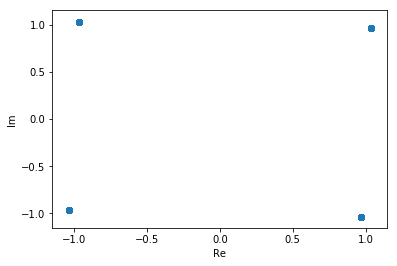

In [92]:
run( plot = True, save = 'task1.png')

In [51]:
#Message and interference are randomly generated Lorem Ipsum text, both of 300 characters

A = str(open("../message.txt","r").read())
interference = str(open("../noise.txt", "r").read())
#phi = alphabetical order of 1st letter of surname + 2x alphabetical order of 1st letter of surname
#phi = 5 + 2(19) = 43
phi = math.radians(43) #in radians

PN1 = [5,2]
PN2 = [5,3,2,1]
polynomials = (PN1, PN2)
offset = 24

PN1J = [5,3]
PN2J = [5,4,2,1]
polynomialsJ = (PN1J, PN2J)

0
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]
[587, 565, 611, 541, 588, 547, 570, 593, 573, 556, 573, 566, 581, 558, 545, 587, 555, 575, 560, 566, 522, 559, 568, 601, 557, 604, 560, 547, 566]


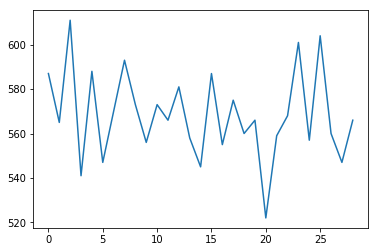

In [59]:
print(run(M = 30, SNRj = 10))
M = list(range(30))
errorCounter = []
for m in M[1:]:
    errorCounter.append(run(SNR=0))
print(M)
print(errorCounter)
plot(errorCounter)